## A toy example of 2D flow optimization using fast neural scene flow with distance transform.

### Load packages

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

from functools import partial
import math
import logging
import numpy as np
import matplotlib
matplotlib.rcParams["font.family"] = "Times New Roman"
from matplotlib import  pyplot as plt

import os
import time

import FastGeodis

device = "cuda" if torch.cuda.is_available() else "cpu"

### Scene flow metrics

In [3]:
# ANCHOR: metrics computation, follow FlowNet3D metrics....
def scene_flow_metrics(pred, labels):
    l2_norm = torch.sqrt(torch.sum((pred - labels) ** 2, 2)).cpu()  # Absolute distance error.
    labels_norm = torch.sqrt(torch.sum(labels * labels, 2)).cpu()
    relative_err = l2_norm / (labels_norm + 1e-20)

    EPE3D = torch.mean(l2_norm).item()  # Mean absolute distance error

    # NOTE: Acc_5
    error_lt_5 = torch.BoolTensor((l2_norm < 0.05))
    relative_err_lt_5 = torch.BoolTensor((relative_err < 0.05))
    acc3d_strict = torch.mean((error_lt_5 | relative_err_lt_5).float()).item()

    # NOTE: Acc_10
    error_lt_10 = torch.BoolTensor((l2_norm < 0.1))
    relative_err_lt_10 = torch.BoolTensor((relative_err < 0.1))
    acc3d_relax = torch.mean((error_lt_10 | relative_err_lt_10).float()).item()

    # NOTE: outliers
    l2_norm_gt_3 = torch.BoolTensor(l2_norm > 0.3)
    relative_err_gt_10 = torch.BoolTensor(relative_err > 0.1)
    outlier = torch.mean((l2_norm_gt_3 | relative_err_gt_10).float()).item()

    # NOTE: angle error
    unit_label = labels / labels.norm(dim=2, keepdim=True)
    unit_pred = pred / pred.norm(dim=2, keepdim=True)
    eps = 1e-7
    dot_product = (unit_label * unit_pred).sum(2).clamp(min=-1+eps, max=1-eps)
    dot_product[dot_product != dot_product] = 0  # Remove NaNs
    angle_error = torch.acos(dot_product).mean().item()

    return EPE3D, acc3d_strict, acc3d_relax, outlier, angle_error


### Visualization

In [12]:
def vis_flow(num_idx, pc1_2d_crop, pc2_2d_crop, flow_2d_crop, title):
    # visualize a portion of the point cloud
    random_idx = np.random.choice(min(pc1_2d_crop.shape[0], pc2_2d_crop.shape[0]), num_idx, replace=False)
    fig = plt.figure(figsize=(13,10))
    plt.scatter(pc1_2d_crop[random_idx,0], pc1_2d_crop[random_idx,1], s=1.5, c='tab:green')
    plt.scatter(pc2_2d_crop[random_idx,0], pc2_2d_crop[random_idx,1], s=1.5, c='tab:purple')
    # plt.plot(flow[:,0])
    ax = plt.gca()
    X = pc1_2d_crop[random_idx,0]
    Y = pc1_2d_crop[random_idx,1]
    U = flow_2d_crop[random_idx,0]
    V = flow_2d_crop[random_idx,1]
    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, width=0.0015, color='tab:orange')

    plt.title(title)

    plt.rcParams.update({'font.size': 20})
    plt.rcParams.update({'font.family': 'Times New Roman'})

    plt.tight_layout()
    plt.show()

### Load scene flow data and visualize

--2023-03-15 07:35:08--  https://docs.google.com/uc?export=download&id=1x8e3MNJhr7ZIBl7upNI64fNSzqX-paPr
Resolving docs.google.com (docs.google.com)... 172.217.214.100, 172.217.214.102, 172.217.214.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2dmfh9n401e9hc8h1mmsdra7otk7jum1/1678865700000/08509246117003492993/*/1x8e3MNJhr7ZIBl7upNI64fNSzqX-paPr?e=download&uuid=604f3c1e-b502-4b21-9564-e650b63a7e30 [following]
--2023-03-15 07:35:09--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2dmfh9n401e9hc8h1mmsdra7otk7jum1/1678865700000/08509246117003492993/*/1x8e3MNJhr7ZIBl7upNI64fNSzqX-paPr?e=download&uuid=604f3c1e-b502-4b21-9564-e650b63a7e30
Resolving doc-14-94-docs.googleusercontent.com (doc-14-94-docs.googleusercontent.com)... 142.250.136.132, 2607:

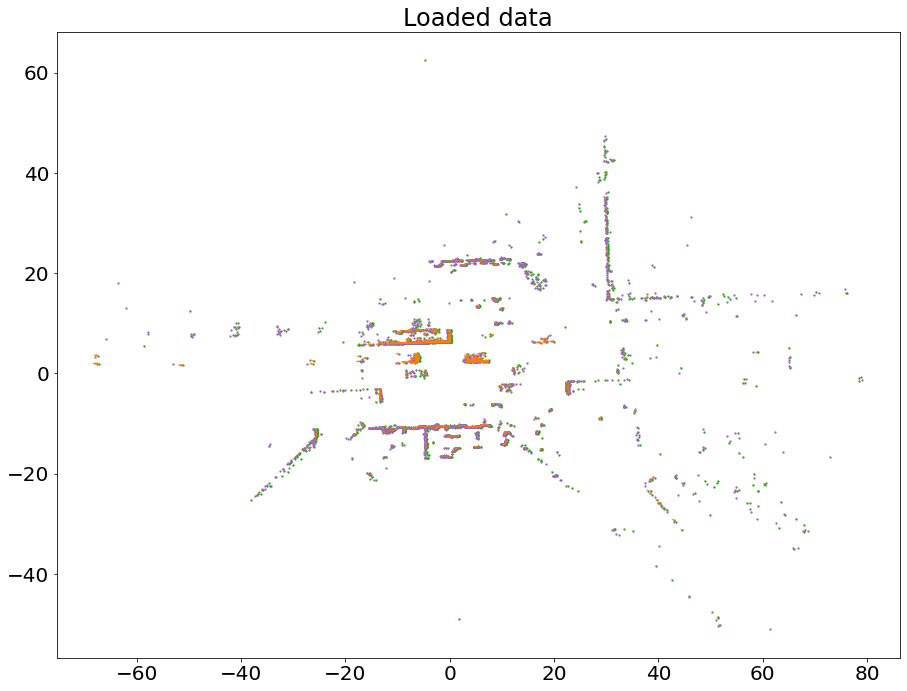

(3679, 2) (3488, 2)


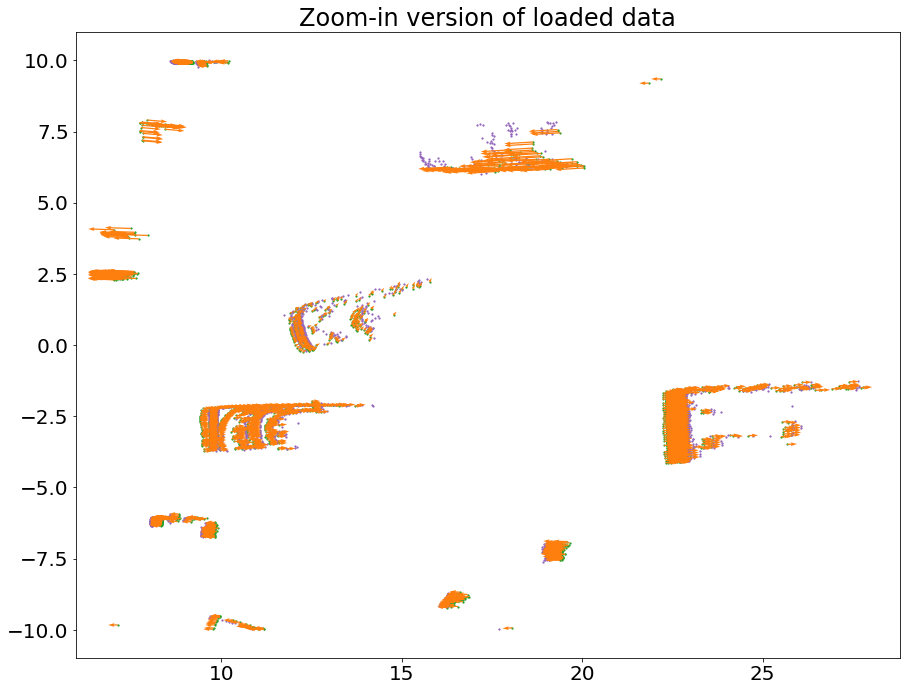

In [24]:
pc_id = "data1"   #'data1', 'data2', 'data3', 'data4'

if pc_id == 'data1':
    !wget --no-check-certificate -O pcs.npz 'https://docs.google.com/uc?export=download&id=1x8e3MNJhr7ZIBl7upNI64fNSzqX-paPr'
elif pc_id == 'data2':
    !wget --no-check-certificate -O pcs.npz 'https://docs.google.com/uc?export=download&id=10QUhXSkCeBiaK2bubBZ0V8y6QXSH_m10'
elif pc_id == 'data3':
    !wget --no-check-certificate -O pcs.npz 'https://docs.google.com/uc?export=download&id=1xehfjIqizluM-f4KdkLHkMPu68Hklv4N'
elif pc_id == 'data4':
    !wget --no-check-certificate -O pcs.npz 'https://docs.google.com/uc?export=download&id=1-pJdy5413bQZka5TZBiptLFY06EkBa3b'

!ls

pc_fi = np.load('pcs.npz', allow_pickle=True)
pc1 = pc_fi['pc1']
pc2 = pc_fi['pc2']
flow = pc_fi['flow']
print(pc1.shape, pc2.shape, flow.shape)
pc1_2d_np = pc1[:,:2]
pc2_2d_np = pc2[:,:2]
flow_2d_np = flow[:,:2]

# visualize 2d flow
num_idx = 3000
vis_flow(num_idx, pc1_2d_np, pc2_2d_np, flow_2d_np, 'Loaded data')

# ANCHOR: visualize a portion of the point cloud (zoom-in)
xmin = 7
xmax = 28
ymin = -10
ymax = 10
idx = np.where(np.logical_and.reduce((pc1_2d_np[:,0] >= xmin, pc1_2d_np[:,0] < xmax,
                                        pc1_2d_np[:,1] >= ymin, pc1_2d_np[:,1] < ymax)))
pc1_2d_crop = pc1_2d_np[idx]
idx2 = np.where(np.logical_and.reduce((pc2_2d_np[:,0] >= xmin, pc2_2d_np[:,0] < xmax,
                                        pc2_2d_np[:,1] >= ymin, pc2_2d_np[:,1] < ymax)))
pc2_2d_crop = pc2_2d_np[idx2]
flow_2d_crop = flow_2d_np[idx]

print(pc1_2d_crop.shape, pc2_2d_crop.shape)
vis_flow(num_idx, pc1_2d_crop, pc2_2d_crop, flow_2d_crop, 'Zoom-in version of loaded data')

### 2D distance transform function

In [6]:
class DT_2D:
    # Calculate the distance transform efficiently using tensors
    def __init__(self, pts, pmin, pmax, pc1_minmax, grid_factor, device='cuda:0'):
        self.device = device
        self.grid_factor = grid_factor
        # self.grid_sample_time = 0.
        
        sample_x = ((pmax[0] - pmin[0]) * grid_factor).ceil().int() + 2
        sample_y = ((pmax[1] - pmin[1]) * grid_factor).ceil().int() + 2
        
        self.Vx = torch.linspace(0, sample_x, sample_x+1, device=self.device)[:-1] / grid_factor + pmin[0]
        self.Vy = torch.linspace(0, sample_y, sample_y+1, device=self.device)[:-1] / grid_factor + pmin[1]
        
        # NOTE: using binary image-based DT
        grid_x, grid_y = torch.meshgrid(self.Vx, self.Vy, indexing="ij")
        self.grid = torch.stack([grid_x.unsqueeze(-1), grid_y.unsqueeze(-1)], -1).float().squeeze()
        
        # NOTE: build a binary image first, with 0-value occuppied points
        H, W, _ = self.grid.size()
        pts_mask = torch.ones(H, W, device=device)
        self.pts_sample_idx_x = ((pts[:,0:1] - self.Vx[0]) * self.grid_factor).round()
        self.pts_sample_idx_y = ((pts[:,1:2] - self.Vy[0]) * self.grid_factor).round()
        pts_mask[self.pts_sample_idx_x.long(), self.pts_sample_idx_y.long()] = 0.
        
        iterations = 1
        image_pts = torch.zeros(H, W, device=device).unsqueeze(0).unsqueeze(0)
        pts_mask = pts_mask.unsqueeze(0).unsqueeze(0)
        self.D = FastGeodis.generalised_geodesic2d(
            image_pts, pts_mask, 1e10, 0.0, iterations
        ).squeeze()
        
    def bilinear_distance(self, Y):
        H, W = self.D.size()
        target = self.D[None, None, ...]
        
        sample_x = ((Y[:,0:1] - self.Vx[0]) * self.grid_factor).clip(0, H-1)
        sample_y = ((Y[:,1:2] - self.Vy[0]) * self.grid_factor).clip(0, W-1)
        
        sample = torch.cat([sample_x, sample_y], -1)
        
        # NOTE: normalize samples to [-1, 1]
        gs_start = time.time()
        sample = 2 * sample
        sample[...,0] = sample[...,0] / (H-1)
        sample[...,1] = sample[...,1] / (W-1)
        sample = sample -1
        sample_ = torch.cat([sample[...,1:2], sample[...,0:1]], -1)
        
        # NOTE: reshape to match 4D volumetric input
        dist = F.grid_sample(target, sample_.view(1,-1,1,2), mode="bilinear", align_corners=True).view(-1)
        return dist
    

### Build distance transform map and visualize

xmin: -77.0999984741211, xmax: 79.5999984741211, ymin: -54.29999923706055, ymax: 64.30000305175781


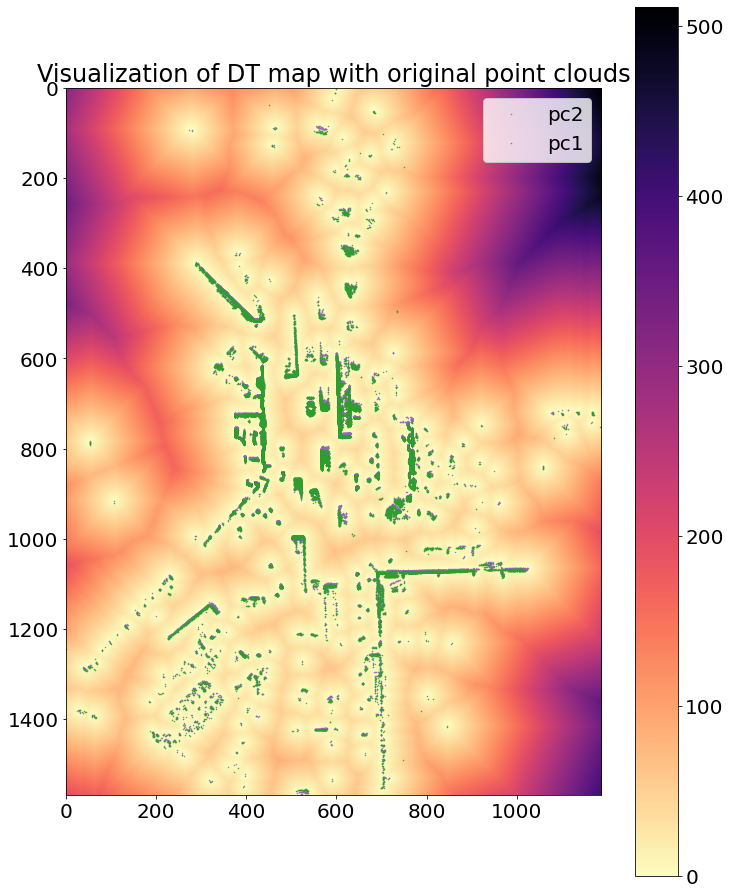

In [25]:
dt_grid_factor = 10 #@param {type:"slider", min:1, max:20, step:1}

# create tensor from numpy point cloud
pc1_2d = torch.from_numpy(pc1_2d_np).to(device)
pc2_2d = torch.from_numpy(pc2_2d_np).to(device)
flow_2d = torch.from_numpy(flow_2d_np).to(device)

pc1_min = torch.min(pc1_2d.squeeze(0), 0)[0]
pc2_min = torch.min(pc2_2d.squeeze(0), 0)[0]

pc1_max = torch.max(pc1_2d.squeeze(0), 0)[0]
pc2_max = torch.max(pc2_2d.squeeze(0), 0)[0]

xmin_int, ymin_int = torch.floor(torch.where(pc1_min<pc2_min, pc1_min, pc2_min) * dt_grid_factor-1) / dt_grid_factor
xmax_int, ymax_int = torch.ceil(torch.where(pc1_max>pc2_max, pc1_max, pc2_max)* dt_grid_factor+1) / dt_grid_factor
print('xmin: {}, xmax: {}, ymin: {}, ymax: {}'.format(xmin_int, xmax_int, ymin_int, ymax_int))

# print(pc1.shape, pc2.shape)
dt = DT_2D(pc2_2d, (xmin_int, ymin_int), (xmax_int, ymax_int), (pc1_min, pc1_max), dt_grid_factor, device)

# NOTE: visualize DT map
plt.figure(figsize=(12,16))
plt.imshow(dt.D.reshape(dt.Vx.shape[0], dt.Vy.shape[0]).cpu().numpy(), cmap="magma_r")

plt.plot((pc2_2d[:,1].cpu().numpy()-ymin_int.item())*dt_grid_factor, (pc2_2d[:,0].cpu().numpy()-xmin_int.item())*dt_grid_factor, '.', c='tab:purple', markersize=1, label="pc2")
plt.plot((pc1_2d[:,1].cpu().numpy()-ymin_int.item())*dt_grid_factor, (pc1_2d[:,0].cpu().numpy()-xmin_int.item())*dt_grid_factor, '.', c='tab:green', markersize=1, label="pc1")
plt.legend(loc="upper right")

plt.colorbar(orientation="vertical")
plt.title('Visualization of DT map with original point clouds')
plt.show()


### Build neural scene flow model

In [9]:
class Neural_Prior(nn.Module):
    def __init__(self, input_size=1000, dim_x=3, filter_size=128, act_fn='relu', layer_size=8, output_feat=False):
        super().__init__()
        self.input_size = input_size
        self.layer_size = layer_size
        self.output_feat = output_feat
        
        self.nn_layers = nn.ModuleList([])
        # input layer (default: xyz -> 128)
        if layer_size >= 1:
            self.nn_layers.append(nn.Sequential(nn.Linear(dim_x, filter_size)))
            if act_fn == 'relu':
                self.nn_layers.append(nn.ReLU())
            elif act_fn == 'sigmoid':
                self.nn_layers.append(nn.Sigmoid())
            elif act_fn == 'exp':
                self.nn_layers.append(GaussianAct())
            for _ in range(layer_size-1):
                self.nn_layers.append(nn.Sequential(nn.Linear(filter_size, filter_size)))
                if act_fn == 'relu':
                    self.nn_layers.append(nn.ReLU())
                elif act_fn == 'sigmoid':
                    self.nn_layers.append(nn.Sigmoid())
                elif act_fn == 'exp':
                    self.nn_layers.append(GaussianAct())
            self.nn_layers.append(nn.Linear(filter_size, dim_x))
        else:
            self.nn_layers.append(nn.Sequential(nn.Linear(dim_x, dim_x)))

    def forward(self, x):
        """ points -> features
            [B, N, 3] -> [B, K]
        """
        if self.output_feat:
            feat = []
        for layer in self.nn_layers:
            x = layer(x)
            if self.output_feat and layer == nn.Linear:
                feat.append(x)

        if self.output_feat:
            return x, feat
        else:
            return x

### Start optimization using distance transform loss

epoch:0, loss:0.7304487824440002
[Ep 0] [Loss: 0.73045]  Metrics: flow 1 --> flow 2 [EPE: 0.300] [Acc strict: 0.793%] [Acc relax: 1.098%] [Angle error (rad): 0.708] [Outl.: 100.000%]
epoch:50, loss:0.26120704412460327
[Ep 50] [Loss: 0.26121]  Metrics: flow 1 --> flow 2 [EPE: 0.054] [Acc strict: 65.955%] [Acc relax: 85.750%] [Angle error (rad): 0.080] [Outl.: 38.232%]
epoch:100, loss:0.22653000056743622
[Ep 100] [Loss: 0.22653]  Metrics: flow 1 --> flow 2 [EPE: 0.034] [Acc strict: 78.621%] [Acc relax: 96.102%] [Angle error (rad): 0.059] [Outl.: 23.629%]
epoch:150, loss:0.21489901840686798
[Ep 150] [Loss: 0.21490]  Metrics: flow 1 --> flow 2 [EPE: 0.027] [Acc strict: 92.568%] [Acc relax: 96.146%] [Angle error (rad): 0.070] [Outl.: 15.176%]
loss:0.21187379956245422, times:4.108421087265015


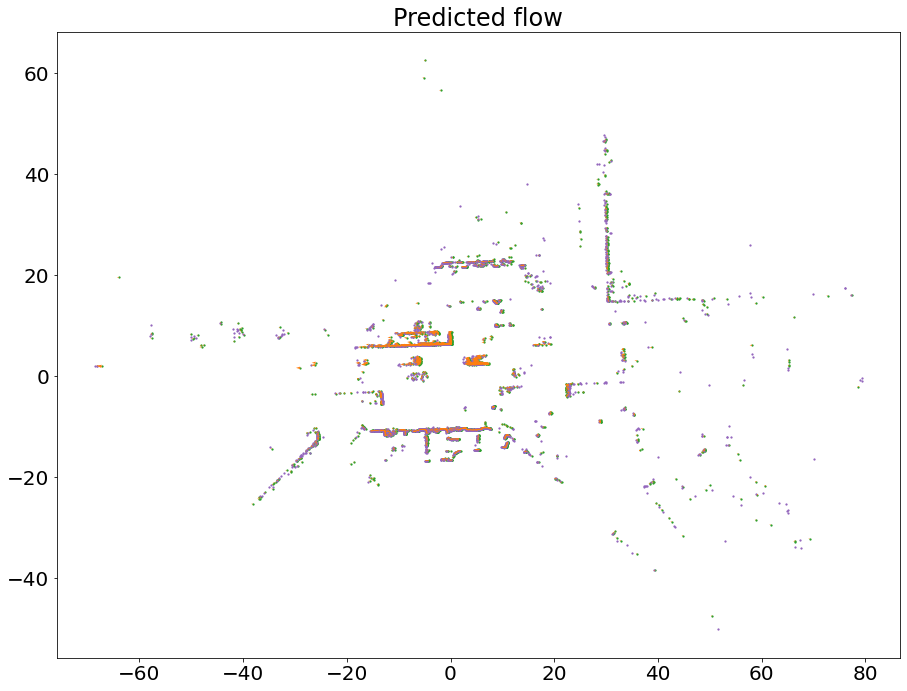

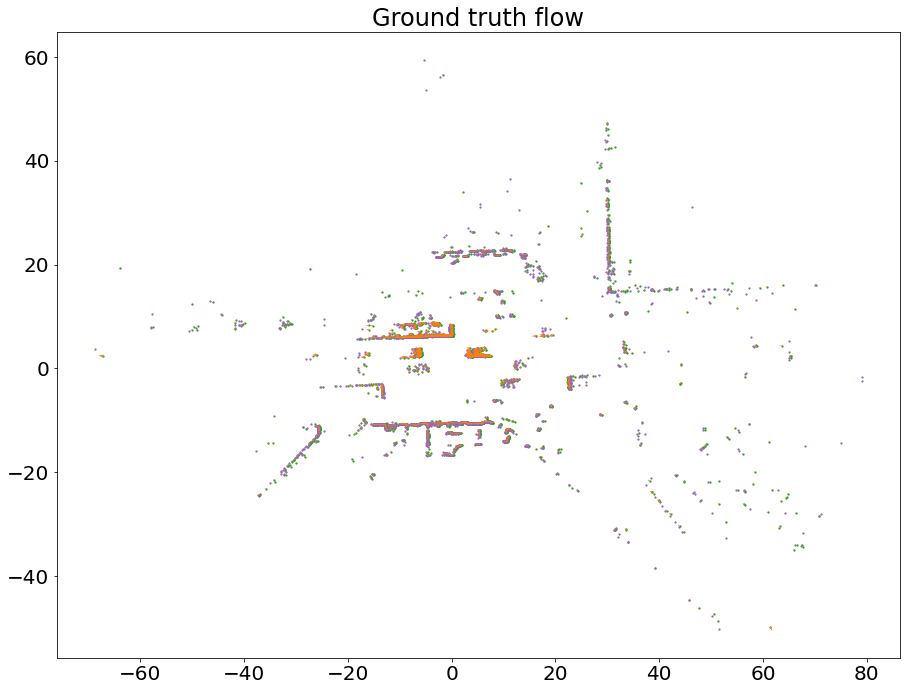

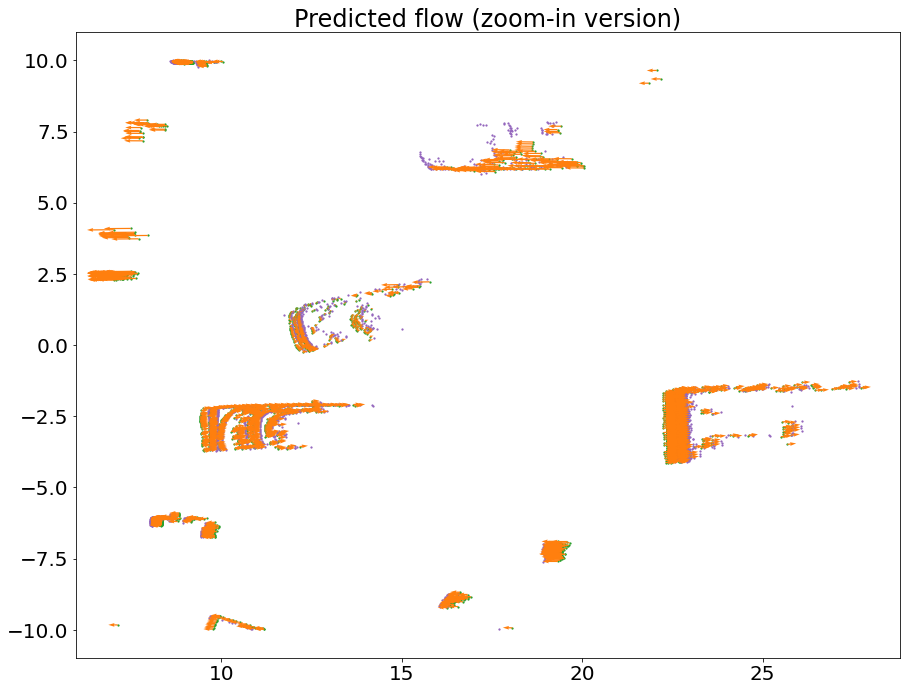

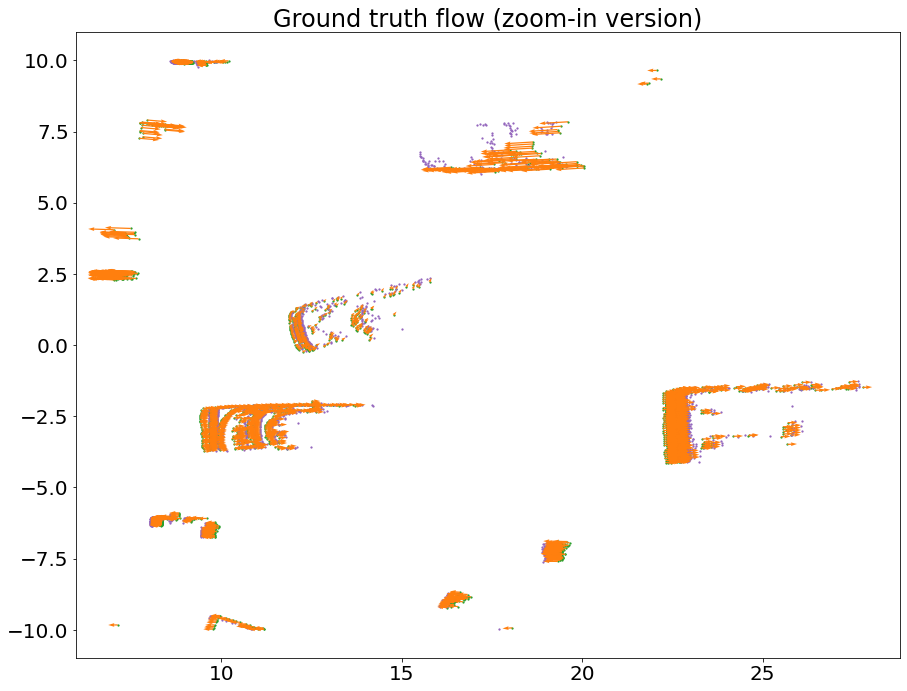

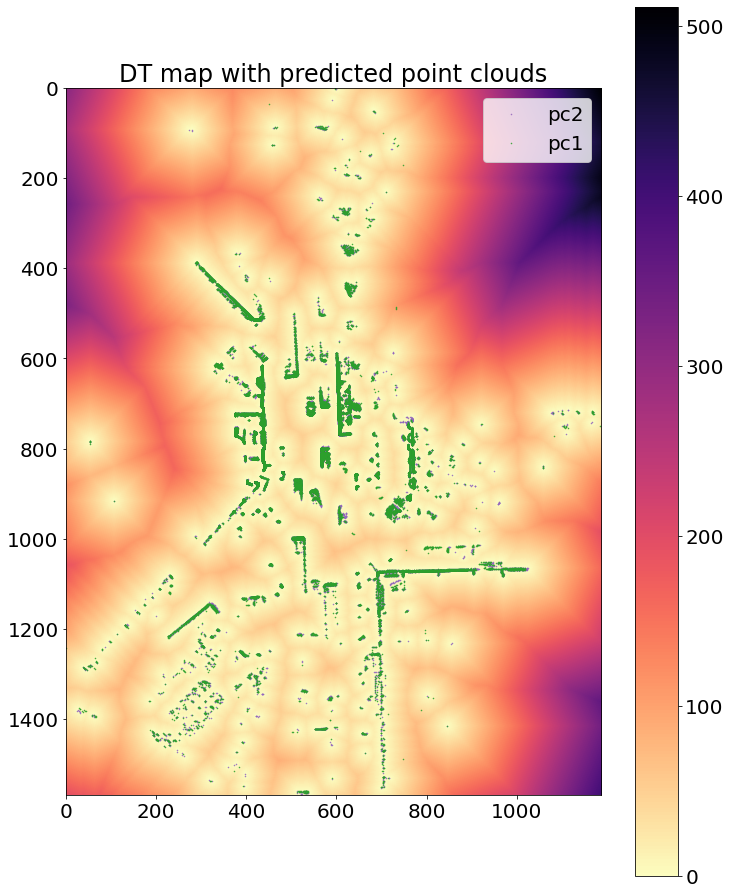

In [28]:
use_dt_loss = True #@param {type:"boolean"}
vis_interval = False #@param {type:"boolean"}
num_points_vis = 3000 #@param {type:"raw", allow-input: true}
epochs = 200 #@param {type:"slider", min:100, max:1000, step:100}
hidden_units = 128 #@param [64,128,256,512]
act_fn = 'relu'
layer_size = 8 #@param [1,2,4,8,10]
lr_nsfp = 0.01 #@param [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 8e-2, 1e-1] {type:"raw", allow-input: true}

net = Neural_Prior(dim_x=2, filter_size=hidden_units, act_fn=act_fn, layer_size=layer_size).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr_nsfp, betas=(0.9, 0.999),weight_decay=1e-8)
start = time.time()

pc1_train = pc1_2d.float().unsqueeze(0).contiguous().to(device)
pc2_train = pc2_2d.float().unsqueeze(0).contiguous().to(device)
flow_train = flow_2d.float().unsqueeze(0).contiguous().to(device)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    flow_pred_1 = net(pc1_train)
    pc1_deformed = pc1_train + flow_pred_1
    
    if use_dt_loss:
      loss = dt.bilinear_distance(pc1_deformed.squeeze(0)).mean()
    
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    
    if epoch % 50 == 0:
        print('epoch:{}, loss:{}'.format(epoch, loss.item()))
        EPE3D_1, acc3d_strict_1, acc3d_relax_1, outlier_1, angle_error_1 = scene_flow_metrics(flow_pred_1, flow_train)
        print(f"[Ep {epoch}] [Loss: {loss.item():.5f}] "
                            f" Metrics: flow 1 --> flow 2"
                            f" [EPE: {EPE3D_1:.3f}] [Acc strict: {acc3d_strict_1 * 100:.3f}%]"
                            f" [Acc relax: {acc3d_relax_1 * 100:.3f}%] [Angle error (rad): {angle_error_1:.3f}]"
                            f" [Outl.: {outlier_1 * 100:.3f}%]")
        
        if vis_interval:
            vis_flow(num_points_vis, pc1_2d, pc2_2d, flow_pred_1.squeeze(0).detach().cpu().numpy())
        
end = time.time()
print('loss:{}, times:{}'.format(losses[-1],end-start))

vis_flow(num_points_vis, pc1_2d_np, pc2_2d_np, flow_pred_1.squeeze(0).detach().cpu().numpy(), 'Predicted flow')
vis_flow(num_points_vis, pc1_2d_np, pc2_2d_np, flow_2d_np, 'Ground truth flow')

vis_flow(num_points_vis, pc1_2d_crop, pc2_2d_crop, flow_pred_1.squeeze(0).detach().cpu().numpy()[idx], 'Predicted flow (zoom-in version)')
vis_flow(num_points_vis, pc1_2d_crop, pc2_2d_crop, flow_2d_crop, 'Ground truth flow (zoom-in version)')


plt.figure(figsize=(12,16))
plt.imshow(dt.D.reshape(dt.Vx.shape[0], dt.Vy.shape[0]).cpu().numpy(), cmap="magma_r")

plt.plot((pc2_2d[:,1].cpu().numpy()-ymin_int.item())*dt_grid_factor, (pc2_2d[:,0].cpu().numpy()-xmin_int.item())*dt_grid_factor, '.', c='tab:purple', markersize=1, label="pc2")
plt.plot((pc1_2d[:,1].cpu().numpy()+flow_pred_1.squeeze(0).detach().cpu().numpy()[:,1]-ymin_int.item())*dt_grid_factor, (pc1_2d[:,0].cpu().numpy()+flow_pred_1.squeeze(0).detach().cpu().numpy()[:,0]-xmin_int.item())*dt_grid_factor, '.', c='tab:green', markersize=1, label="pc1")
plt.legend(loc="upper right")

plt.colorbar(orientation="vertical")
plt.title('DT map with predicted point clouds')
plt.show()
